In [1]:
# Data sources:
# 1. boston_road_massdot2015_MA.dbf, given by CoB
# 2. massdot_crashes_12_14_MA.dbf, given by CoB after associating each accident co-ordinate to the road segment (FID)
# 3. crashes_12-14.csv, Original data from MassDOT aggregated and by Josiah 

In [2]:
# Convert dbf to csv
import pandas as pd
%matplotlib inline
import matplotlib as plt
from simpledbf import Dbf5
dbf_incident_data = Dbf5('massdot_crashes_12_14_MA.dbf',codec='utf-8')
incident_data = dbf_incident_data.to_dataframe()

In [3]:
# CoB data has truncated columns names from ArcGIS , fix that using Josiah's dataset
original = pd.read_csv('crashes_12-14.csv')
full_column_name = original.columns.tolist()
trunc_column_name = incident_data.columns.tolist()
full_column_name.extend(trunc_column_name[-5:])
incident_data.columns = full_column_name

# Convert column names into lowercase
incident_data.columns = [x.lower().strip() for x in incident_data.columns.tolist()]

In [4]:
# A single accident can have multiple entries, one for each vehicle involved in the crash
# Clean massdot crash data file to make single crash record for each row

# remove vehicle related details as its not possible to retain multiple vehicle details in a single row
incident_data.drop('vehicle_number',axis=1,inplace=True)
incident_data.drop('vehicle_configuration',axis=1,inplace=True)
incident_data.drop('vehicle_travel_directions',axis=1,inplace=True)
incident_data.drop('vehicle_action_prior_to_crash',axis=1,inplace=True)

# remove byte order mark from crash_number column
incident_data.rename(columns={'\xef\xbb\xbfcrash_number':'crash_number'}, inplace=True)


In [5]:
#Each incident is reported as multiple crashes. If one crash involves 2 vehicles, 2 crash reports are filed
#Making each incident has one entry
incident_data.drop_duplicates('crash_number', inplace=True)

# remove records without location records
incident_data = incident_data[incident_data['near_fid'] != -1]

In [6]:
#convert date to three new columns 'year', 'day' and 'hour' of crash report
from datetime import datetime
date_to_dayofweek_converter = lambda x: datetime.strptime(str(x), '%Y-%m-%d').strftime('%a')
date_to_year_converter = lambda x: datetime.strptime(str(x), '%Y-%m-%d').strftime('%y')

def time_to_hour_converter(x):
    if x == '0S':
        return -1
    else:
        return datetime.strptime(str(x), '%HH %MM %SS').strftime('%H')

incident_data['day'] = incident_data['crash_date'].apply(date_to_dayofweek_converter)
incident_data['year'] = incident_data['crash_date'].apply(date_to_year_converter)
incident_data['hour'] = incident_data['crash_time'].apply(time_to_hour_converter)

In [7]:
# read road data from csv to create a dataframe and convert column names to lowercase
dbf_roads_data = Dbf5('boston_road_massdot2015_MA.dbf',codec='utf-8')
road_data = dbf_roads_data.to_dataframe()
road_data.columns = road_data.columns.str.lower()
print road_data.columns

Index([u'objectid', u'route_id', u'from_measu', u'to_measure', u'from_date',
       u'to_date', u'control', u'facility', u'f_class', u'urban_area',
       u'urban_type', u'f_f_class', u'jurisdictn', u'hwy_dist', u'hwy_subdst',
       u'med_width', u'med_type', u'mile_count', u'nhs', u't_exc_type',
       u't_exc_time', u'trk_permit', u'trk_netwrk', u'truck_rte', u'num_lanes',
       u'opp_lanes', u'iri', u'iri_year', u'psi', u'psi_year', u'row_width',
       u'shldr_lt_w', u'shldr_lt_t', u'shldr_rt_w', u'shldr_rt_t',
       u'speed_lim', u'op_dir_sl', u'st_name', u'fm_st_name', u'to_st_name',
       u'city', u'county', u'operation', u'struct_cnd', u'surface_tp',
       u'surface_wd', u'terrain', u'toll_road', u'aadt', u'aadt_year',
       u'aadt_deriv', u'statn_num', u'curb', u'shldr_ul_w', u'shldr_ul_t',
       u'lt_sidewlk', u'rt_sidewlk', u'mhs', u'mpo', u'fd_aid_rd',
       u'districtnu', u'shape_leng', u'strsegfid', u'near_fid', u'count_near',
       u'nmacrashes', u'near_fid_1', 

In [8]:
# Join crash_data and road_data on near_fid and strsegfid
crash_road_data = incident_data.merge(road_data, left_on='near_fid', right_on='strsegfid', how='left')

#drop zero information columms or duplicates
crash_road_data.drop('city_town_name',axis=1, inplace='True')
crash_road_data.drop('city_x',axis=1, inplace='True')
crash_road_data.drop('city_y',axis=1, inplace='True')
crash_road_data.drop('date_time',axis=1, inplace='True')
crash_road_data.drop('near_fid_y',axis=1, inplace='True')
crash_road_data.drop('near_fid_1',axis=1, inplace='True')
crash_road_data.drop('strsegfid',axis=1, inplace='True')
crash_road_data.drop('mpo',axis=1, inplace='True')

# save merged dataset
crash_road_data.to_csv('crash_road_12_14_MA_unique.csv')

11559
14622
2931


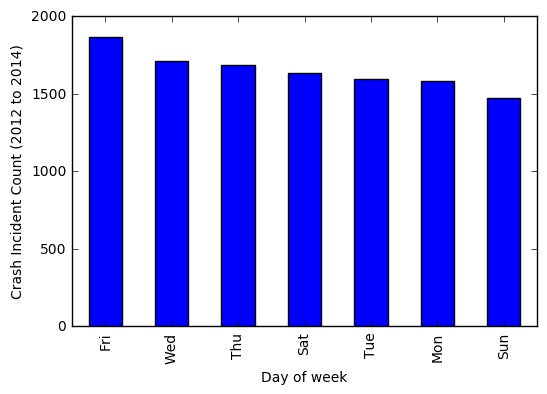

In [14]:
#basic analysis

#Total accident reports from 2012 to 2014 with valid FID data : 11559
print len(crash_road_data)

#Total number of street segments in boston : 14,622
print len(road_data)

#Number of street segments that has seen a crash : 2,932
print len(crash_road_data.near_fid_x.unique())

#number of crashes every weekday
ax = crash_road_data.day.value_counts().plot(kind='bar')
ax.set_xlabel('Day of week')
ax.set_ylabel('Crash Incident Count (2012 to 2014)')

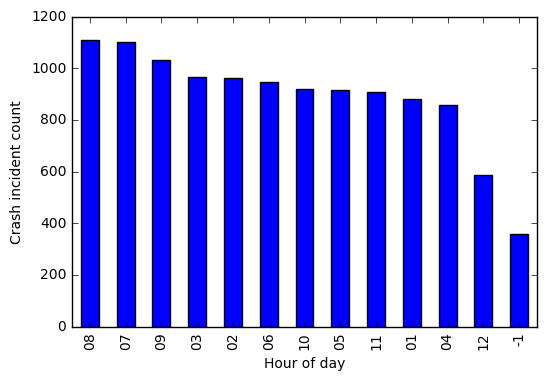

In [15]:
#number of crashes vs hour of day (-1 where the data has no time entry)
# not sure only 12 hours, there was not AM PM details in the data
ax = crash_road_data.hour.value_counts().plot(kind='bar')
ax.set_xlabel('Hour of day')
ax.set_ylabel('Crash incident count')

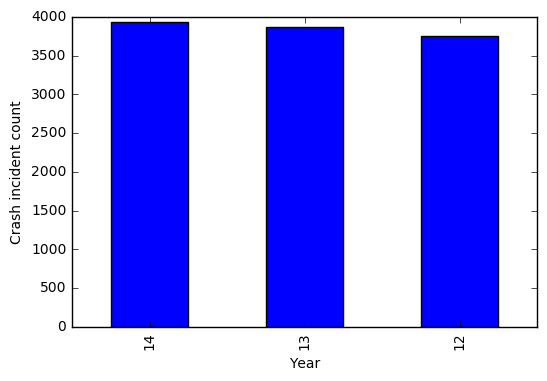

In [16]:
#number of crashes each year
ax = crash_road_data.year.value_counts().plot(kind='bar')
ax.set_xlabel('Year')
ax.set_ylabel('Crash incident count')

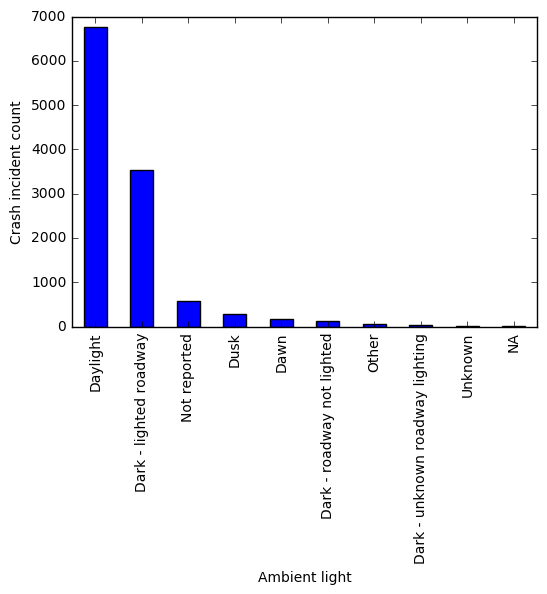

In [17]:
#number of crashes vs ambient light
ax = crash_road_data.ambient_light.value_counts().plot(kind='bar')
ax.set_xlabel('Ambient light')
ax.set_ylabel('Crash incident count')

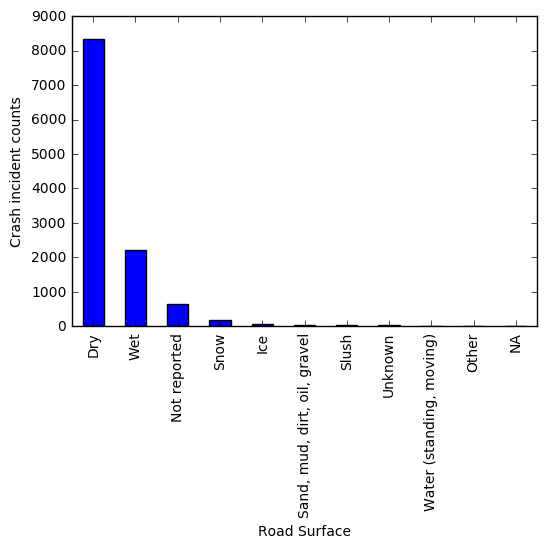

In [18]:
#number of crashes vs road surface 
ax = crash_road_data.road_surface_condition.value_counts().plot(kind='bar')
ax.set_xlabel('Road Surface')
ax.set_ylabel('Crash incident counts')

1     0.801713
3     0.095597
7     0.058396
5     0.014448
11    0.010901
4     0.009084
0     0.006488
10    0.003201
12    0.000173
Name: facility, dtype: float64


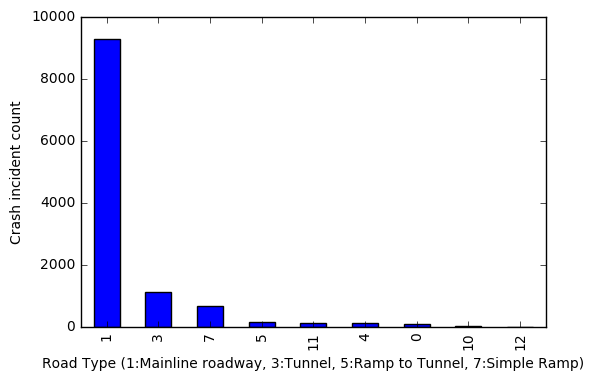

In [24]:
#number of crashes vs facility type
ax = crash_road_data.facility.value_counts().plot(kind='bar')
ax.set_xlabel('Road Type (1:Mainline roadway, 3:Tunnel, 5:Ramp to Tunnel, 7:Simple Ramp)')
ax.set_ylabel('Crash incident count')
print crash_road_data.facility.value_counts(normalize=True)

1     0.816167
0     0.103748
7     0.040760
3     0.019012
11    0.011900
5     0.004035
4     0.002736
12    0.001094
10    0.000547
Name: facility, dtype: float64
83185
35642


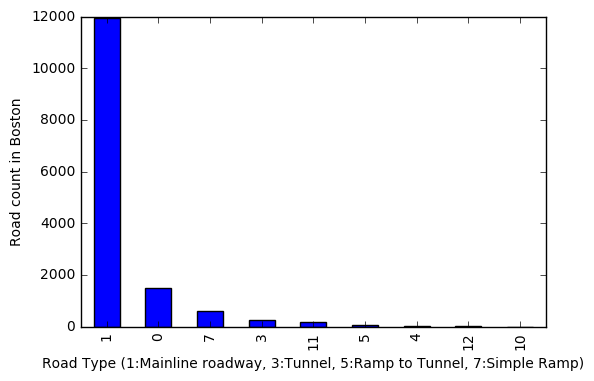

In [25]:
# the top 3 dangerous facilities are (1,3,7) i.e (Mainline roadway, Tunnel, Simple Ramp)
ax = road_data.facility.value_counts().plot(kind='bar')
ax.set_xlabel('Road Type (1:Mainline roadway, 3:Tunnel, 5:Ramp to Tunnel, 7:Simple Ramp)')
ax.set_ylabel('Road count in Boston')
print road_data.facility.value_counts(normalize=True) 

# Tunnels are 1.9% of all roads but , 9.5% of all crashes happened in tunnels. Maybe tunnels have high AADT?

# Average tunnel AADT vs Average total road AADT
total_tunnels = len(road_data[road_data['facility'] == 3])
tunnels_with_aadt = len(road_data[ (road_data['facility'] == 3) & (road_data['aadt'] != 0)])

total_aadt = sum(road_data[(road_data['facility'] == 3) & (road_data['aadt'] != 0)].aadt.tolist())

average_aadt_in_tunnels = total_aadt/tunnels_with_aadt
print average_aadt_in_tunnels

# Average aadt in all roads
total_roads = len(road_data)
roads_with_aadt = len(road_data[road_data['aadt'] > 1000])
total_aadt_roads = sum(road_data[road_data['aadt'] > 1000].aadt.tolist())
average_aadt = total_aadt_roads/roads_with_aadt
print average_aadt


In [26]:
# Total fatal crashes
import numpy as np
injury_road_data = crash_road_data[(crash_road_data['total_fatal_injuries'] > 0) | (crash_road_data['total_nonfatal_injuries'] > 0)]
len(injury_road_data)

grouped_facility = crash_road_data.groupby('facility') 
print grouped_facility['total_fatal_injuries'].agg(np.sum)
print grouped_facility['total_nonfatal_injuries'].agg(np.sum)


facility
0      0
1     63
3      2
4      1
5      0
7      1
10     0
11     0
12     0
Name: total_fatal_injuries, dtype: int64
facility
0       26
1     4288
3      321
4       42
5       72
7      206
10       8
11      32
12       0
Name: total_nonfatal_injuries, dtype: int64


1     0.849878
3     0.066902
7     0.044602
5     0.015502
4     0.007887
11    0.007343
0     0.005983
10    0.001904
Name: facility, dtype: float64


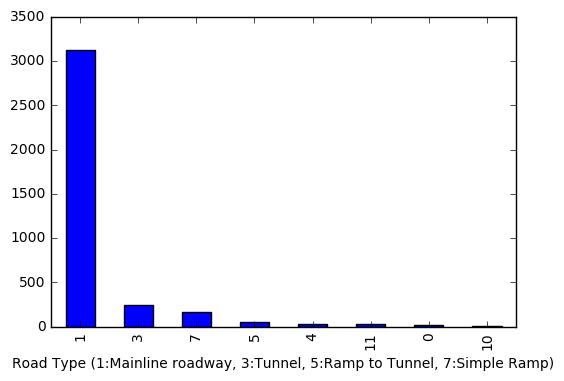

In [27]:
#number of fatal crashes vs facility type
ax = injury_road_data.facility.value_counts().plot(kind='bar')
ax.set_xlabel('Road Type (1:Mainline roadway, 3:Tunnel, 5:Ramp to Tunnel, 7:Simple Ramp)')
print injury_road_data.facility.value_counts(normalize=True)

# Tunnels are 1.9% of all roads and cause 6.6 percent of all injury crashes

0    0.469245
2    0.185570
6    0.182109
1    0.112640
5    0.044727
3    0.005710
Name: med_type, dtype: float64


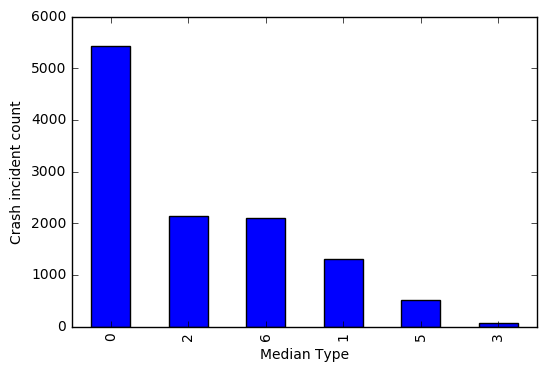

In [28]:
#number of crashes vs median type
ax = crash_road_data.med_type.value_counts().plot(kind='bar')
ax.set_xlabel('Median Type')
ax.set_ylabel('Crash incident count')
print crash_road_data.med_type.value_counts(normalize=True) 

0    0.794898
1    0.088634
2    0.048010
6    0.044385
5    0.013268
3    0.010806
Name: med_type, dtype: float64


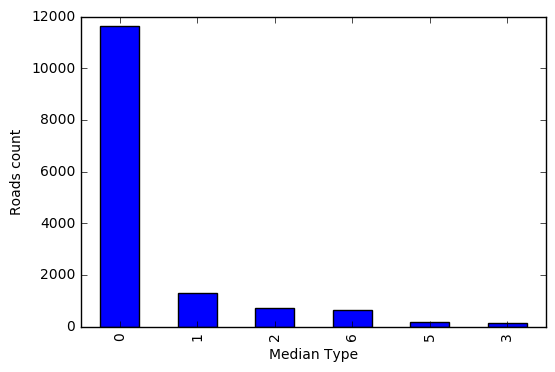

In [29]:
ax = road_data.med_type.value_counts().plot(kind='bar')
ax.set_xlabel('Median Type')
ax.set_ylabel('Roads count')
print road_data.med_type.value_counts(normalize=True) 

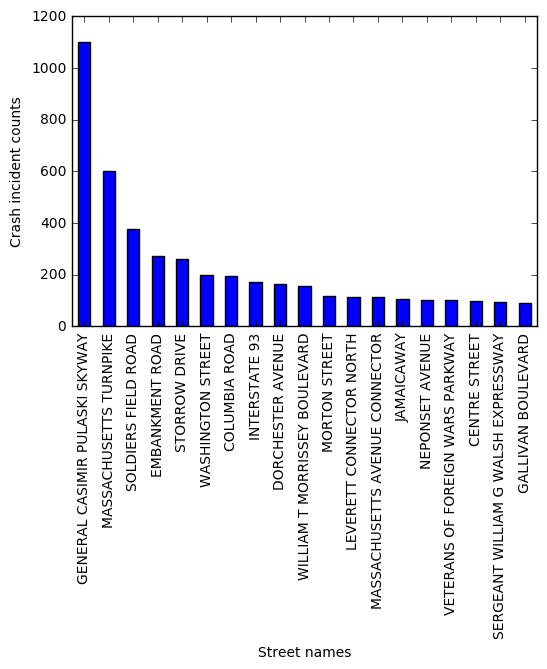

In [33]:
#High crash streets
ax = crash_road_data.st_name.value_counts().iloc[1:20].plot(kind='bar')
ax.set_xlabel('Street names')
ax.set_ylabel('Crash incident counts')

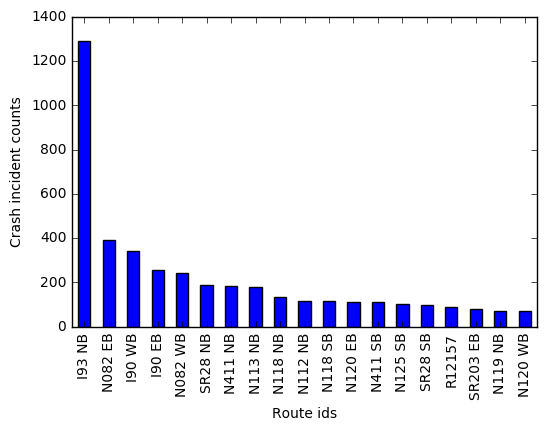

In [34]:
#High crash route ids
ax = crash_road_data.route_id.value_counts().iloc[1:20].plot(kind='bar')
ax.set_xlabel('Route ids')
ax.set_ylabel('Crash incident counts')

In [35]:
# number of crashes at intersection vs segments 
intersection_crashes = crash_road_data[crash_road_data['at_roadway_intersection'] != 'NA']
intersection_crashes['intersection_road1'], intersection_crashes['intersection_road2'] = intersection_crashes['at_roadway_intersection'].str.split(' / ',1).str

/Users/anoop/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [37]:
# 3391 crashes out of 11920 crashes happened at intersections ~ 28% of crashes happenned at intersections
intersection_crashes.to_csv("intersection_crashes.csv")
print "Intersection " 
print "Total incidents : ", len(intersection_crashes)
print "Total nonfatal injuries : ", sum(intersection_crashes['total_nonfatal_injuries'].tolist())
print "Total fatal injuries : ", sum(intersection_crashes['total_fatal_injuries'].tolist())

print "All roads "
print "Total incidents : " , len(crash_road_data)
print "Total nonfatal injuries : ", sum(crash_road_data['total_nonfatal_injuries'].tolist())
print "Total fatal injuries : ", sum(crash_road_data['total_fatal_injuries'].tolist())


Intersection 
Total incidents :  3391
Total nonfatal injuries :  1874
Total fatal injuries :  27
All roads 
Total incidents :  11559
Total nonfatal injuries :  4995
Total fatal injuries :  67


/Users/anoop/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


                                at_roadway_intersection  \
2066    WILLIAM T MORRISSEY BOULEVARD / FREEPORT STREET   
484                      COLUMBUS AVENUE / HEATH STREET   
902                     HARRISON AVENUE / DUDLEY STREET   
792              GALLIVAN BOULEVARD / DORCHESTER AVENUE   
1613                        RIVERWAY / BROOKLINE AVENUE   
967                   HUMBOLDT AVENUE / TOWNSEND STREET   
778   FRONTAGE ROAD / MASSACHUSETTS AVENUE CONNECTOR...   
1279                     MORTON STREET / HARVARD STREET   
1868  VETERANS OF FOREIGN WARS PARKWAY / LA GRANGE S...   
1091                   KNEELAND STREET / LINCOLN STREET   
1344  NEW RUTHERFORD AVENUE Rte SR99 N / CHELSEA STREET   
445                       COLUMBIA ROAD / GENEVA AVENUE   
482                  COLUMBUS AVENUE / DARTMOUTH STREET   
457                       COLUMBIA ROAD / QUINCY STREET   
1734               STORROW DRIVE / CHARLESGATE OVERPASS   
241                    BOWDOIN STREET / HAMILTON STREET 

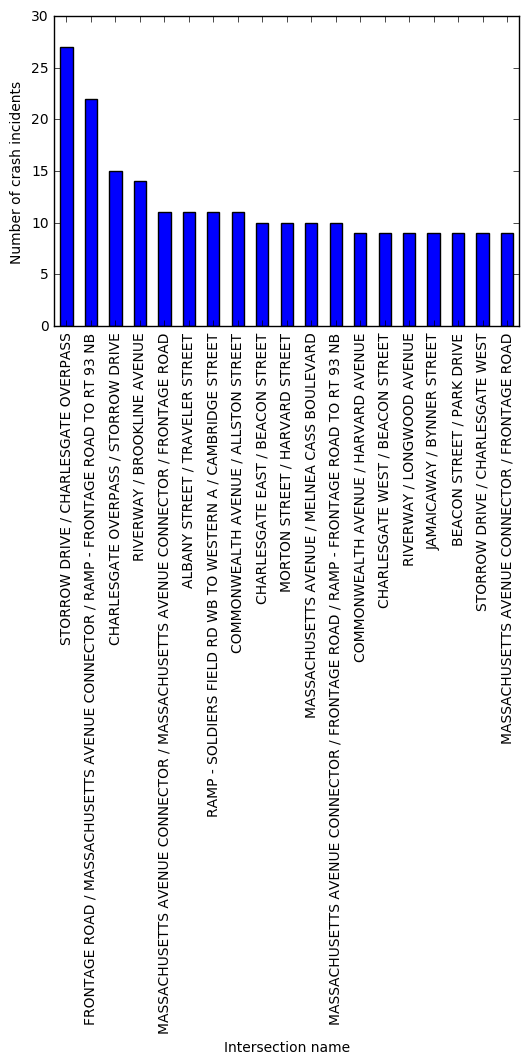

In [38]:
#High crash intersections
ax = intersection_crashes.at_roadway_intersection.value_counts().iloc[1:20].plot(kind='bar')
ax.set_xlabel('Intersection name')
ax.set_ylabel('Number of crash incidents')

grouped_intersections = intersection_crashes.groupby('at_roadway_intersection')
intersection_injuries = grouped_intersections['total_nonfatal_injuries'].agg(np.sum).reset_index()
print intersection_injuries.sort('total_nonfatal_injuries', ascending=False)[:20]